In [297]:
import warnings
warnings.filterwarnings('ignore')

In [298]:
import pandas as pd
import numpy as np
import struct
from importlib import reload

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier 

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, train_test_split, cross_val_score

from hyperopt import fmin, tpe, hp
from bayes_opt import BayesianOptimization

from scipy.stats import entropy
from scipy import sparse

import matplotlib.pyplot as plt

from copy import deepcopy as copy

%matplotlib inline

In [299]:
import sys
sys.path.append('../../')

In [336]:
import mlrank.dichtomization as dichtomization
import mlrank.orthogonalization as orthogonalization
import mlrank.hyperparams_opt as hyperparams_opt

reload(dichtomization)
reload(orthogonalization)
reload(hyperparams_opt)

MaxentropyMedianDichtomizationTransformer = dichtomization.MaxentropyMedianDichtomizationTransformer
MLRankTransformer = orthogonalization.MLRankTransformer
MLRankTargetBasedTransformer = orthogonalization.MLRankTargetBasedTransformer
bayesian_optimization_lightgbm = hyperparams_opt.bayesian_optimization_lightgbm

# Breast Cancer

In [442]:
df = pd.read_csv('./datasets/cancer/breast_cancer.csv')
y = df.diagnosis.replace('M', 0).replace('B', 1).values
X = np.asarray(df.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1).as_matrix())

In [443]:
X = StandardScaler().fit_transform(X)

In [444]:
models = {
    #'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000, tol=1e-6, random_state=12512),
}

In [445]:
transform = MLRankTransformer(models['lr'], exhausitve=True, verbose=1)
# используем SVC, так как LR не сходится по энтропии к таргету на данном датасете
transform_target_min_equi = MLRankTargetBasedTransformer(models['svc'], verbose=1, use_xor=False, use_max_entropy=False)
transform_target_max_xor = MLRankTargetBasedTransformer(models['svc'], verbose=1, use_xor=True, use_max_entropy=True)

In [446]:
features, indices = transform.fit_transform(X)

processing starting feature 0
processing starting feature 1
processing starting feature 2
processing starting feature 3
processing starting feature 4
processing starting feature 5
processing starting feature 6
processing starting feature 7
processing starting feature 8
processing starting feature 9
processing starting feature 10
processing starting feature 11
processing starting feature 12
processing starting feature 13
processing starting feature 14
processing starting feature 15
processing starting feature 16
processing starting feature 17
processing starting feature 18
processing starting feature 19
processing starting feature 20
processing starting feature 21
processing starting feature 22
processing starting feature 23
processing starting feature 24
processing starting feature 25
processing starting feature 26
processing starting feature 27
processing starting feature 28
processing starting feature 29


In [413]:
features_target_min_equi, indices_target_min_equi = transform_target_min_equi.fit_transform(X, y.reshape(-1, 1))
features_target_max_xor, indices_target_max_xor = transform_target_max_xor.fit_transform(X, y.reshape(-1, 1))

In [414]:
print(indices_target_min_equi) # пересечение с истинным оптимальным ('6', '20', '21', '27', '28')
print(indices_target_max_xor) # пересечение с истинным оптимальным и с ранжированными коэффициентыми логистической регрессии [2, 22, 21, 13, 20]

[24, 8, 0, 1]
[22, 20, 0]


## Считаем точность на оптимальном сабсете, полученном из таргета (min, <\-\>)

In [416]:
X_train, X_val, y_train, y_val = train_test_split(X[:, indices_target_min_equi], y, test_size=0.1)

In [417]:
stats = {}

for k, model in models.items():
    stats[k] = []
    kfold = KFold(n_splits=32, shuffle=True)
    
    for train_ix, test_ix in kfold.split(X_train, y_train):
        X_crossval_train, X_crossval_test = X_train[train_ix], X_train[test_ix]
        y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]
        
        # here must be sume sort of optimization
        model.fit(X_crossval_train, y_crossval_train.ravel())
        stats[k].append(accuracy_score(model.predict(X_crossval_test), y_crossval_test, normalize=True))
    print(k + ' is ready')

lr is ready
svc is ready


In [418]:
print('for pure data (averate scores):')
for model, model_stats in stats.items():
    print('{}, Accuracy: {}'.format(model, np.mean(model_stats)))

for pure data (averate scores):
lr, Accuracy: 0.9609375
svc, Accuracy: 0.888671875


In [419]:
from scipy import sparse

print('for pure data (validation scores):')
for name, model in models.items():
    model.fit(X_train, y_train.squeeze())
    print('pure: {}, Accuracy: {}'.format(name, accuracy_score(model.predict(X_val), y_val.squeeze())))

for pure data (validation scores):
pure: lr, Accuracy: 0.9649122807017544
pure: svc, Accuracy: 0.9298245614035088


### Ортогонализуем специально под SVC

In [420]:
optimal_transform = MLRankTransformer(models['svc'], exhausitve=False, verbose=1)

In [421]:
features_min_equi, _  = optimal_transform.fit_transform(
    np.hstack([X[:, i].reshape(-1, 1) for i in indices_target_min_equi])
)

In [422]:
X_train, X_val, y_train, y_val = train_test_split(features_min_equi, y, test_size=0.1)

In [423]:
stats = {}

for k, model in models.items():
    stats[k] = []
    kfold = KFold(n_splits=32, shuffle=True)
    
    for train_ix, test_ix in kfold.split(X_train, y_train):
        X_crossval_train, X_crossval_test = X_train[train_ix], X_train[test_ix]
        y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]
        
        # here must be sume sort of optimization
        model.fit(X_crossval_train, y_crossval_train.ravel())
        stats[k].append(accuracy_score(model.predict(X_crossval_test), y_crossval_test, normalize=True))
    print(k + ' is ready')

lr is ready
svc is ready


In [424]:
print('for pure data (averate scores):')
for model, model_stats in stats.items():
    print('{}, Accuracy: {}'.format(model, np.mean(model_stats)))

for pure data (averate scores):
lr, Accuracy: 0.8515625
svc, Accuracy: 0.83984375


In [425]:
print('for pure data (validation scores):')
for name, model in models.items():
    model.fit(X_train, y_train.squeeze())
    print('pure: {}, Accuracy: {}'.format(name, accuracy_score(model.predict(X_val), y_val.squeeze())))

for pure data (validation scores):
pure: lr, Accuracy: 0.8245614035087719
pure: svc, Accuracy: 0.8596491228070176


### Считаем точность на оптимальном сабсете, полученном из таргета (max, xor)

In [426]:
X_train, X_val, y_train, y_val = train_test_split(X[:, indices_target_max_xor], y, test_size=0.1)

In [427]:
stats = {}

for k, model in models.items():
    stats[k] = []
    kfold = KFold(n_splits=32, shuffle=True)
    
    for train_ix, test_ix in kfold.split(X_train, y_train):
        X_crossval_train, X_crossval_test = X_train[train_ix], X_train[test_ix]
        y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]
        
        # here must be sume sort of optimization
        model.fit(X_crossval_train, y_crossval_train.ravel())
        stats[k].append(accuracy_score(model.predict(X_crossval_test), y_crossval_test, normalize=True))
    print(k + ' is ready')

lr is ready
svc is ready


In [428]:
print('for pure data (averate scores):')
for model, model_stats in stats.items():
    print('{}, Accuracy: {}'.format(model, np.mean(model_stats)))

for pure data (averate scores):
lr, Accuracy: 0.931640625
svc, Accuracy: 0.837890625


In [429]:
from scipy import sparse

print('for pure data (validation scores):')
for name, model in models.items():
    model.fit(X_train, y_train.squeeze())
    print('pure: {}, Accuracy: {}'.format(name, accuracy_score(model.predict(X_val), y_val.squeeze())))

for pure data (validation scores):
pure: lr, Accuracy: 0.9649122807017544
pure: svc, Accuracy: 0.9298245614035088


### Ортогонализуем специально под SVC

In [430]:
optimal_transform = MLRankTransformer(models['svc'], exhausitve=False, verbose=1)

In [431]:
features_max_xor, _  = optimal_transform.fit_transform(
    np.hstack([X[:, i].reshape(-1, 1) for i in indices_target_max_xor])
)

In [432]:
X_train, X_val, y_train, y_val = train_test_split(features_min_equi, y, test_size=0.1)

In [433]:
stats = {}

for k, model in models.items():
    stats[k] = []
    kfold = KFold(n_splits=32, shuffle=True)
    
    for train_ix, test_ix in kfold.split(X_train, y_train):
        X_crossval_train, X_crossval_test = X_train[train_ix], X_train[test_ix]
        y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]
        
        # here must be sume sort of optimization
        model.fit(X_crossval_train, y_crossval_train.ravel())
        stats[k].append(accuracy_score(model.predict(X_crossval_test), y_crossval_test, normalize=True))
    print(k + ' is ready')

lr is ready
svc is ready


In [434]:
print('for pure data (averate scores):')
for model, model_stats in stats.items():
    print('{}, Accuracy: {}'.format(model, np.mean(model_stats)))

for pure data (averate scores):
lr, Accuracy: 0.8515625
svc, Accuracy: 0.83984375


In [435]:
from scipy import sparse

print('for pure data (validation scores):')
for name, model in models.items():
    model.fit(X_train, y_train.squeeze())
    print('pure: {}, Accuracy: {}'.format(name, accuracy_score(model.predict(X_val), y_val.squeeze())))

for pure data (validation scores):
pure: lr, Accuracy: 0.8245614035087719
pure: svc, Accuracy: 0.8596491228070176


### Смотрим важность факторов из оригинального алгоритма

In [451]:
unique_ix = np.unique(indices).tolist()
ix_counts = {i: 0 for i in unique_ix}

for row in indices:
    ranks = dict(zip(row.tolist(), reversed(range(row.shape[0]))))
    for i, j in ranks.items():
        ix_counts[i] += j / (row.shape[0]**2)

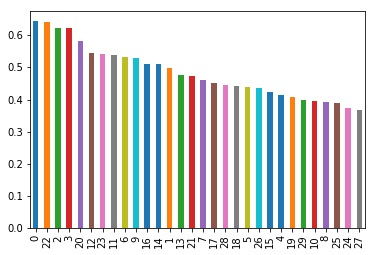

In [452]:
pd.Series(ix_counts).sort_values(ascending=False).plot(kind='bar')

### Смотрим на коэффициенты в логистической регрессии (важность факторов)

In [447]:
model_coefs = []

for x_features in features:
    c = copy(models['lr'])
    c.fit(x_features, y)
    
    # summing over unique target values (32)
    model_coefs.append(np.abs(c.coef_).sum(0))
model_coefs = np.array(model_coefs)

In [448]:
model_coefs = [model_coefs[:, i*32:(i+1)*32] for i in range(model_coefs.shape[1] // 32)]

In [449]:
model_coefs_sum = [model_coefs[i].sum() for i in range(len(model_coefs))]

In [453]:
# ну, в принципе, все логично.

sorted(zip(model_coefs_sum, range(len(model_coefs_sum))), key=lambda x: -x[0])

[(6501.048444484562, 0),
 (2784.105410820018, 2),
 (2751.226754856094, 1),
 (1777.2283380194494, 3),
 (1496.0120716155757, 4),
 (946.761073054619, 7),
 (907.22703662351, 5),
 (695.9662365201209, 6),
 (525.2466402060338, 8),
 (358.31551280490163, 28),
 (357.9587375531405, 9),
 (330.9450551739628, 11),
 (328.46859485945777, 10),
 (326.9093318802111, 12),
 (299.21448440456174, 20),
 (283.0209292172931, 24),
 (253.86328686186704, 27),
 (240.4338882477633, 16),
 (232.51441717931064, 13),
 (231.59589301148648, 18),
 (230.70837069606293, 17),
 (230.52978794430527, 26),
 (230.0462985646567, 14),
 (223.1259073071525, 25),
 (222.23476856777322, 19),
 (219.74685163336932, 21),
 (206.8316342753421, 15),
 (199.7402642723128, 23),
 (190.22380952682596, 22)]